## Import necessary libraries

In [2]:
import cv2 #OpenCV library for computer vision tasks
import math #Standard Python library for mathematical functions
import numpy as np #Library for numerical computing in Python
import os #Standard Python library for interacting with the operating system
import pm4py #Process mining library in Python
import pandas as pd #Library for data manipulation and analysis
from PIL import Image #Python Imaging Library for image processing tasks
import glob #Standard Python library for file path matching
import json #Standard Python library for working with JSON data
import graphviz #Library for creating and rendering graph visualizations
from matplotlib import pyplot as plt #Library for creating data visualizations in Python
import tensorflow as tf #Open-source machine learning framework

#Keras - High-level API for building and training deep learning models in TensorFlow
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

## Creat classes to implement a method of patterns detection in process logs

In [3]:
# A custom exception class
class MyException(Exception):
    pass

In [4]:
class PatternsConverter():
    """
    A class for converting event logs to activity matrices and saving them as images.

    Attributes:
    -----------
    act_dict : dict or None
        A dictionary of activity names and their indices.
    log_file_path : str
        The path to the input event log file.
    caseID_col_name : str
        The name of the column containing case IDs in the event log.
    act_col_name : str
        The name of the column containing activity names in the event log.
    ts_col_name : str
        The name of the column containing timestamps in the event log.
    event_log : pandas.DataFrame
        The preprocessed event log containing only the necessary columns.
    traces_num : int
        The number of traces in the event log.
    max_len_prefix_trace : int
        The length of the longest prefix trace.
    cases_prefix_traces : list
        A list of lists containing the prefix traces for each case.
    activity_matrices : list
        A list of activity matrices for each case.
    act_dict = None
    """
    
    @classmethod
    def set_activities_dict(cls, act_dict):
        """
        Set the activities dictionary to be used for converting activities to integer values.

        Parameters:
        -----------
        act_dict : dict
            Dictionary containing activity names as keys and integer values as values.
        """
        cls.act_dict = act_dict

    
    def __init__(self, log_file_path, caseID_col_name, act_col_name, ts_col_name):
        
        """
        Initialize the PatternsConverter class with the specified parameters.

        Parameters:
        -----------
        log_file_path : str
            The path to the log file.
        caseID_col_name : str
            The name of the column containing the case IDs.
        act_col_name : str
            The name of the column containing the activity names.
        ts_col_name : str
            The name of the column containing the timestamps.
        """
        
        self.log_file_path = log_file_path
        
        self.caseID_col_name = caseID_col_name 
        self.act_col_name = act_col_name
        self.ts_col_name = ts_col_name
        
        #self.event_log = pd.read_csv(log_file_path, sep=ch_sep)
        self.event_log = pm4py.read_xes(log_file_path)
        self.event_log[caseID_col_name]=self.event_log[caseID_col_name].apply(str)
        self.event_log[act_col_name]=self.event_log[act_col_name].apply(str)
        self.traces_num = 0
        self.event_log[ts_col_name]= pd.to_datetime(self.event_log[ts_col_name], utc=True, dayfirst=True)
        self.event_log[ts_col_name]= self.event_log[ts_col_name].dt.strftime('%Y-%m-%d %H:%M:%S')
    

        self.event_log = self.event_log[[act_col_name, caseID_col_name, ts_col_name]]
        

    def __get_unique_ids(self):
        """
        Get a list of unique case IDs from the event log.

        Returns:
        --------
        list
            A list of unique case IDs.
        """
        ids = list(self.event_log[self.caseID_col_name].unique())
        self.traces_num = len(ids)
        return ids

    def __get_case_logs(self, ids_list):
        """
        Get a list of case logs (traces) from the event log, based on the specified list of case IDs.

        Parameters:
        -----------
        ids_list : list
            A list of case IDs.

        Returns:
        --------
        list
            A list of case logs.
        """
        case_logs = []
        for id in ids_list:
            case_log = self.event_log.query("`{0}` == @id".format(self.caseID_col_name))
            case_log.sort_values(by=[self.ts_col_name])
            if len(case_log) > 2:
                case_logs.append(case_log)
        return case_logs

    def __get_prefix_traces(self):
        """
        Get a list of prefix traces for each case in the event log.

        Returns:
        --------
        list
            A list of prefix traces for each case in the event log.
        """
        cases_prefix_traces = []
        self.max_len_prefix_trace = 0

        for case_log in self.case_logs:
            prefix_traces_act = []
            for i in range(1, len(case_log) + 1):
                prefix_trace = []
                
                if "pattern_bounded_3_times" not in self.log_file_path:
                    prefix_trace = case_log[self.act_col_name].values[0:i]
                else:
                    prefix_trace = case_log[0:i]
                   
                # find the longest prefix trace
                if len(prefix_trace) > self.max_len_prefix_trace:
                    self.max_len_prefix_trace = len(prefix_trace)
                
                
                prefix_traces_act.append(prefix_trace)
                

            cases_prefix_traces.append(prefix_traces_act)
            
        return cases_prefix_traces

    def __get_activity_matrices(self):
        """
        Returns a list of activity matrices, where each matrix represents the frequency of occurrence of each activity in each
        prefix trace of the log file. The method iterates over the list of prefix traces, for each prefix trace it generates a
        matrix where each row represents an moment of time in the trace and each column represents an activity in the activity
        dictionary. Then it populates the matrix with the frequency of occurrence of each activity in each position of the prefix
        trace. Finally, it converts the matrix to a numpy array and appends it to the list of activity matrices.

        Returns:
        --------
            list: A list of numpy arrays representing the activity matrices.
        """
        activity_matrices = []
        for prefix_traces in self.cases_prefix_traces:
            np_matrix = []
            matrix = [[0] * len(PatternsConverter.act_dict) for i in range(self.max_len_prefix_trace)]
            for i in range(len(prefix_traces)):
                for act in prefix_traces[i]:
                    act_index = PatternsConverter.act_dict[act]
                    matrix[i][act_index] += 1
            np_matrix = np.asmatrix(matrix)
            np_matrix = np_matrix.astype("uint8")
            activity_matrices.append(np_matrix)
        return activity_matrices

    def convert(self, path_to_dir):
        """
        Converts the log file to a set of images representing the frequency of occurrence of each activity in each prefix trace
        of the log file. The method first retrieves the unique case ids from the log file and then obtains the prefix traces for
        each case. Next, it generates a list of activity matrices where each matrix represents the frequency of occurrence of
        each activity in each prefix trace. For each activity matrix, the method normalizes the values to fit within the range
        [0, 255] and converts it to a grayscale image. Finally, it saves each image to disk with a filename following the format
        'image_{index}.png' and returns the list of activity matrices.

        Args:
            path_to_dir (str): The path to the directory where the images will be saved.

        Returns:
        --------
            list: A list of numpy arrays representing the activity matrices.
        """
        ids_list = self.__get_unique_ids()

        if "pattern_bounded_3_times" not in self.log_file_path:
            self.case_logs = self.__get_case_logs(ids_list)
        else:
            matrix = [["Start", "Ist", "A", "A", "A", "Icmp", "End"]] * 1000
            self.case_logs = matrix
        
        self.cases_prefix_traces = self.__get_prefix_traces()
        self.activity_matrices = self.__get_activity_matrices()

        index = 1

        for np_matrix in self.activity_matrices:
           
            norm_matrix = np_matrix.copy()
            norm_matrix *= 255.0 / norm_matrix.max()
            activity_chanel = np.squeeze(np.asarray(norm_matrix))
            activity_chanel = activity_chanel.astype(int)

            result = cv2.merge([activity_chanel, activity_chanel, activity_chanel])
            path = path_to_dir + "/image_" + str(index) + ".png"

            # resize image
            result = cv2.resize(result, (256, 256), interpolation=cv2.INTER_NEAREST)

            cv2.imwrite(path, result)
            index += 1


In [5]:
class LogConverter():
    """
    An utility class for converting a log file in XES format into a set of activity matrices and image files.
        
    Attributes:
    -----------
        act_dict (dict or None): A dictionary mapping activity names to integers, used for encoding the activity
            matrix. If None, the dictionary must be provided to the class using the `set_activities_dict` method.
        log_file_path (str): The path to the input log file in XES format.
        caseID_col_name (str): The name of the column containing the case ID in the input log file.
        act_col_name (str): The name of the column containing the activity name in the input log file.
        ts_col_name (str): The name of the column containing the timestamp in the input log file.
        event_log (pandas.DataFrame): A dataframe containing the parsed log file, with columns `act_col_name`,
            `caseID_col_name`, and `ts_col_name`.
        traces_num (int): The number of unique case IDs in the input log file.
        case_logs (list): A list of dataframes, where each dataframe contains the log entries for a single case ID.
        cases_prefix_traces (list): A list of tuples, where each tuple contains two lists of activity sequences. The
            first list contains the prefix traces for a case, and the second list contains the remaining trace. Each
            activity sequence is a list of activity names.
        activity_matrices (list): A list of tuples, where each tuple contains an activity matrix (as a numpy array) and
            the corresponding trace (as a list of activity names).
    """
    
    act_dict = None
    
    @classmethod
    def set_activities_dict(cls, act_dict):
        """
        Set the activities dictionary to be used for converting activities to integer values.

        Parameters:
        -----------
        act_dict : dict
            Dictionary containing activity names as keys and integer values as values.
        """
        cls.act_dict = act_dict
       
    
    def __init__(self, log_file_path, caseID_col_name, act_col_name, ts_col_name):
        
        """
        Initialize the PatternsConverter class with the specified parameters.

        Parameters:
        -----------
        log_file_path : str
            The path to the log file.
        caseID_col_name : str
            The name of the column containing the case IDs.
        act_col_name : str
            The name of the column containing the activity names.
        ts_col_name : str
            The name of the column containing the timestamps.
        """
        
        self.log_file_path = log_file_path
        
        self.caseID_col_name = caseID_col_name 
        self.act_col_name = act_col_name
        self.ts_col_name = ts_col_name

        #self.event_log = pd.read_csv(log_file_path, sep=ch_sep)
        self.event_log = pm4py.read_xes(log_file_path)
        self.event_log[caseID_col_name]=self.event_log[caseID_col_name].apply(str)
        self.event_log[act_col_name]=self.event_log[act_col_name].apply(str)
        self.traces_num = 0
        self.event_log[ts_col_name]= pd.to_datetime(self.event_log[ts_col_name], utc=True, dayfirst=True)
        self.event_log[ts_col_name]= self.event_log[ts_col_name].dt.strftime('%Y-%m-%d %H:%M:%S')

        self.event_log = self.event_log[[act_col_name, caseID_col_name, ts_col_name]]
        
    
    def __get_unique_ids(self):
        """
        Get a list of unique case IDs from the event log.

        Returns:
        --------
        list
            A list of unique case IDs.
        """
        ids = list(self.event_log[self.caseID_col_name].unique())
        self.traces_num = len(ids)
        return ids

    def __get_case_logs(self, ids_list):
        """
        Get a list of case logs (traces) from the event log, based on the specified list of case IDs.

        Parameters:
        -----------
        ids_list : list
            A list of case IDs.

        Returns:
        --------
        list
            A list of case logs.
        """
        case_logs = []
        for id in ids_list:
            #case_log = self.event_log.query("`{0}` == @id".format(self.caseID_col_name))
            case_log = self.event_log[self.event_log[self.caseID_col_name] == id]
            case_log.sort_values(by=[self.ts_col_name])
            if len(case_log) > 2:
                case_logs.append(case_log)
           
        return case_logs

    def __get_prefix_traces(self):
        """
        Get a list of prefix traces for each case in the event log.

        Returns:
        --------
        list
            A list of prefix traces for each case in the event log.
        """
        cases_prefix_traces = []
        self.max_len_prefix_trace = 0

        for case_log in self.case_logs:
            prefix_traces_act = []
            trace = list(case_log.to_records(index=False)[1:].tolist())
            
            for i in range(1, len(case_log) + 1):
                prefix_trace = case_log[self.act_col_name].values[0:i]
                
                # находим самую длинную префиксную трассу
                if len(prefix_trace) > self.max_len_prefix_trace:
                    self.max_len_prefix_trace = len(prefix_trace)
                
                
                prefix_traces_act.append(prefix_trace)
                

            cases_prefix_traces.append((prefix_traces_act, trace))
            #print(prefix_traces_act)
        return cases_prefix_traces

    def __get_activity_matrices(self):
        """
        Returns a list of activity matrices, where each matrix represents the frequency of occurrence of each activity in each
        prefix trace of the log file. The method iterates over the list of prefix traces, for each prefix trace it generates a
        matrix where each row represents an moment of time in the trace and each column represents an activity in the activity
        dictionary. Then it populates the matrix with the frequency of occurrence of each activity in each position of the prefix
        trace. Finally, it converts the matrix to a numpy array and appends it to the list of activity matrices.

        Returns:
        --------
            list: A list of numpy arrays representing the activity matrices.
        """
        activity_matrices = []
        for prefix_traces, trace in self.cases_prefix_traces:
            np_matrix = []
            matrix = [[0] * len(LogConverter.act_dict) for i in range(self.max_len_prefix_trace)]
            for i in range(len(prefix_traces)):
                for act in prefix_traces[i]:
                    act_index = LogConverter.act_dict[act]
                    matrix[i][act_index] += 1
            np_matrix = np.asmatrix(matrix)
            np_matrix = np_matrix.astype("uint8")
            activity_matrices.append((np_matrix, trace))
        return activity_matrices
    
    def convert(self, path_to_img_dir, log_data_json_path):
        """
        Converts the log file to a set of images representing the frequency of occurrence of each activity in each prefix trace
        of the log file. The method first retrieves the unique case ids from the log file and then obtains the prefix traces for
        each case. Next, it generates a list of activity matrices where each matrix represents the frequency of occurrence of
        each activity in each prefix trace. For each activity matrix, the method normalizes the values to fit within the range
        [0, 255] and converts it to a grayscale image. Finally, it saves each image to disk with a filename following the format
        'image_{index}.png' and returns the list of activity matrices.

        Args:
            path_to_dir (str): The path to the directory where the images will be saved.

        Returns:
        --------
            list: A list of numpy arrays representing the activity matrices.
        """
        ids_list = self.__get_unique_ids()
        self.case_logs = self.__get_case_logs(ids_list)
        
        self.cases_prefix_traces = self.__get_prefix_traces()
        self.activity_matrices = self.__get_activity_matrices()

        index = 1

        tuple_data = []
        for np_matrix, trace in self.activity_matrices:
            norm_matrix = np_matrix.copy()
            norm_matrix *= 255.0 / norm_matrix.max()
            activity_chanel = np.squeeze(np.asarray(norm_matrix))
            activity_chanel = activity_chanel.astype(int)

            result = cv2.merge([activity_chanel, activity_chanel, activity_chanel])
            path = path_to_img_dir + "/image_" + str(index) + ".png"

            # resize image
            result = cv2.resize(result, (256, 256), interpolation=cv2.INTER_NEAREST)

            cv2.imwrite(path, result)

            pair = (path, list(trace))
            tuple_data.append(pair)

            index += 1
            
        with open(log_data_json_path, 'w') as f:
            json.dump(tuple_data, f)

In [6]:
class ModelLoader():
    """
        A class for loading, preprocessing and training the model for recognizing
        behavioral patterns in XES logs.
    """
    def __init__(self, mode, path_patterns_img_dir, paths_patterns_XES_data=None, 
                 caseID_col_name=None, act_col_name=None, ts_col_name=None):
        """
        Constructor method for the ModelLoader class.

        Args:
        - mode: int
            Determines the mode of the ModelLoader instance.
            - mode=0: requires the paths to the patterns XES data and names of data coilumns
            - mode=1: does not require the paths to the patterns XES data
        - path_patterns_img_dir: str
            The path to the directory that will contain the pattern images.
        - paths_patterns_XES_data: list of str, optional (default=None)
            The list of paths to the XES files that contain the pattern data. Required if mode=0.
        - caseID_col_name: str, optional (default=None)
            The name of the column that contains the case IDs in the XES data.
        - act_col_name: str, optional (default=None)
            The name of the column that contains the activity names in the XES data.
        - ts_col_name: str, optional (default=None)
            The name of the column that contains the timestamps in the XES data.
        """
        
        self.path_patterns_img_dir = path_patterns_img_dir
        self.act_dict = None
        match mode:
            case 0:
                self.paths_patterns_XES_data = paths_patterns_XES_data
            
                self.caseID_col_name = caseID_col_name 
                self.act_col_name = act_col_name
                self.ts_col_name = ts_col_name
                self.__convert_data_to_img()
            case 1:
                pass
            case _:
                raise MyException("Wrong mode! Allowed modes are 0 and 1!")
                        
        
    def __convert_data_to_img(self):
        """
        Converts the pattern data in XES format to images and saves them to the specified directory.
        """
        activities = set()
        for path in self.paths_patterns_XES_data:
            log = pm4py.read_xes(path)
            for act in pd.unique(log[self.act_col_name].values.ravel()):
                activities.add(act)
        
        activities = sorted(activities)
        # проводим соответствие между номером и активити
        act_num = len(activities)
        self.act_dict = {}
        for i in range(act_num):
            self.act_dict[activities[i]] = i
        
        PatternsConverter.set_activities_dict(self.act_dict)
        
        for path in self.paths_patterns_XES_data:
            act_conv = PatternsConverter(path, self.caseID_col_name, self.act_col_name, self.ts_col_name)
            name = os.path.basename(path)
            size = len(name)
            path_to_pattern_dir = self.path_patterns_img_dir + "/" + name[:size-4]
            if not os.path.exists(path_to_pattern_dir):
                os.makedirs(path_to_pattern_dir)
            act_conv.convert(path_to_pattern_dir)
        
    def get_act_dict(self):
        """
        Returns the activity dictionary.
        
        Raises:
        - MyException: if the activity dictionary is not available.
        """
        if self.act_dict != None:
            return self.act_dict
        else:
            raise MyException("act_dict is not available!")
            
            
    def load_scale_data(self, show_sample):
        """
        Loads the pattern images from the specified directory and scales them.

        Args:
        - show_sample: bool
            Determines whether to show a sample of the loaded data or not.
        """
        self.img_data = tf.keras.utils.image_dataset_from_directory(self.path_patterns_img_dir)
        self.class_names = self.img_data.class_names
        
        if show_sample:
            data_iterator = self.img_data.as_numpy_iterator()
            batch = data_iterator.next()
            fig, ax = plt.subplots(ncols=4, figsize=(20,20))
            for idx, img in enumerate(batch[0][:4]):
                ax[idx].imshow(img.astype(int))
                ax[idx].title.set_text(batch[1][idx])
                
        self.img_data = self.img_data.map(lambda x,y: (x/255, y))
        if show_sample:
            self.img_data.as_numpy_iterator().next()
    
    def split_data(self, train_size_prop, val_size_prop, test_size_prop):
        """
        Splits the data into training, validation, and testing sets based on
        the proportion of data to allocate for each set.

        Args:
        - train_size_prop (float): Proportion of data to allocate for training.
        -  val_size_prop (float): Proportion of data to allocate for validation.
        -  test_size_prop (float): Proportion of data to allocate for testing.

        Returns:
            None
        Raises:
            MyException: If any of the proportions are out of range.

        """
        arr = np.array([train_size_prop, val_size_prop, test_size_prop])

        if (arr >= 0).all() and (arr <= 1).all() and int(sum(arr)+0.01) == 1:
            train_size = int(len(self.img_data)*train_size_prop)
            val_size = int(len(self.img_data)*val_size_prop)
            test_size = int(len(self.img_data)*test_size_prop)
            print("Whole data size is " + str(len(self.img_data)) + "\nTraining data size is " + str(train_size))
            
            self.train = self.img_data.take(train_size)
            self.val = self.img_data.skip(train_size).take(val_size)
            self.test = self.img_data.skip(train_size+val_size).take(test_size)
        else:
            raise MyException("Some of the proportions are out of range!")
            
    def __build_model(self):
        """
        Builds the sequential convolutional neural network model using tf.keras .
        """
        self.model = Sequential()
        num_classes = len(self.img_data)

        self.model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(2,2))
        
        self.model.add(Conv2D(32, (3,3), 1, activation='relu'))
        self.model.add(BatchNormalization())
        
        self.model.add(Conv2D(16, (3,3), 1, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D((2,2)))
        
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(4, activation='softmax'))
        
        self.model.compile(optimizer=Adam(learning_rate=1e-06), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    def __train_model(self, number_epochs, add_data_autotune):
        """
        Trains the model on the training set.

        Args:
        - number_epochs (int): The number of epochs to train the model for.
        - add_data_autotune (bool): Whether to enable data autotuning.
        """
        
        if add_data_autotune:
            AUTOTUNE = tf.data.AUTOTUNE
            self.train = self.train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
            self.val = self.val.cache().prefetch(buffer_size=AUTOTUNE)
            
        logdir='logs'
        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
        
        self.hist = self.model.fit(self.train, epochs = number_epochs, validation_data=self.val, callbacks=[tensorboard_callback])
    
    def plot_model_performance(self):
        """
        Plots the performance of the model during training.
        """
        fig = plt.figure()
        plt.plot(self.hist.history['loss'], color='teal', label='loss')
        plt.plot(self.hist.history['val_loss'], color='orange', label='val_loss')
        fig.suptitle('Loss', fontsize=20)
        plt.legend(loc="upper left")
        plt.show()
        
        fig = plt.figure()
        plt.plot(self.hist.history['accuracy'], color='teal', label='accuracy')
        plt.plot(self.hist.history['val_accuracy'], color='orange', label='val_accuracy')
        fig.suptitle('Accuracy', fontsize=20)
        plt.legend(loc="upper left")
        plt.show()
        
    def model_summary(model):
        """
        Prints a summary of the model.

        Args:
            model (keras.Model): The model to print the summary of.
        """
        print(model.summary())
    
    def create_model(self, number_epochs, add_data_autotune):
        """
        Creates and trains the convolutional neural network model.

        Args:
        - number_epochs (int): The number of epochs to train the model for.
        - add_data_autotune (bool): Whether to enable data autotuning.

        Returns:
            tuple: A tuple containing the trained model and a dictionary mapping class indices to class names.

        """

        self.__build_model()
        self.__train_model(number_epochs, add_data_autotune)
        return (self.model, (self.act_dict, self.class_names))
    
    def get_class_names():
        """
        Returns the class names (names of patterns) on which the model was trained.
        
        Returns:
            list: A list of class names.

        """
        return self.class_names
    
    @classmethod
    def save_model(cls, model, path_to_model_dir, model_name, info_data, path_to_info_dir, model_info_name):
        """
        Saves the model and its associated data to files.

        Args:
        - model (keras.Model): The model to save.
        - path_to_model_dir (str): The directory to save the model file in.
        - model_name (str): The name to use for the model file.
        - info_data (dict): The data associated with the model.
        - path_to_info_dir (str): The directory to save the model info file in.
        - model_info_name (str): The name to use for the model info file.

        Raises:
            MyException: If a model with the same name already exists.

        """
        model_path = os.path.join(path_to_model_dir, model_name + ".h5")
        if os.path.isfile(model_path) is False:
            model.save(model_path)

            info_path = os.path.join(path_to_info_dir, model_info_name + ".json")
            data = (model_path, info_data)
            with open(info_path, 'w') as f:
                json.dump(data, f)
        else:
            raise MyException("Model with such name already exists!")
        
    @classmethod
    def load_built_model(cls, path_to_info_data):
        """
        Loads a built model and its associated data from a file.

        Args:
            path_to_info_data (str): The path to the file containing the model data.

        Returns:
            tuple: A tuple containing the loaded model and its associated data.

        """
        data = ()
        with open(path_to_info_data, 'r') as f:
            data = json.load(f)
        
        return data

In [7]:
class LogLoader:
    
    """
    A class that loads event log data and converts it to a format that can be used for further analysis.

    Attributes:
    -----------
        mode: int
            Determines how the data is loaded.
            - case 0: Loads data from a log file and converts it to JSON format.
            - case 1: Loads data from a JSON file.
        log_data_json_path: str
            The path to the JSON file where the log data is stored.
        act_dict: dict, optional
            A dictionary that maps activity names to IDs.
        log_file_path: str, optional
            The path to the log file to be loaded. Required if mode is 0.
        path_to_img_dir: str, optional
            The path to the directory where images related to the log data are stored. Required if mode is 0.
        caseID_col_name: str, optional
            The name of the column in the log file that contains the case ID. Required if mode is 0.
        act_col_name: str, optional
            The name of the column in the log file that contains the activity name. Required if mode is 0.
        ts_col_name: str, optional
            The name of the column in the log file that contains the timestamp. Required if mode is 0.

    Methods:
    --------
    __init__(self, mode, log_data_json_path, act_dict=None, log_file_path=None, path_to_img_dir=None,
             caseID_col_name=None, act_col_name=None, ts_col_name=None)
        Initializes the LogLoader object with the given parameters.
    __convert_data(self)
        Converts the log data from the log file to JSON format and stores it in the img_trace_data attribute.
    get_img_trace_data(self)
        Returns the converted log data in JSON format.
    """

    def __init__(self, mode, log_data_json_path, act_dict = None, log_file_path=None, 
                 path_to_img_dir = None, caseID_col_name=None, act_col_name=None,
                 ts_col_name=None):
        """
            Constructor for LogLoader class - initializes a new instance of the LogLoader class.
            
            Args:
            - mode: The mode to use when loading the log data. If mode is 0, the traces will be loaded from a log file, converted to images and this pair converted to a JSON format. If mode is 1, the data will be loaded directly from a JSON file.
            - log_data_json_path: The path to the JSON file containing the data.
            - act_dict: A dictionary containing activity names and their corresponding activity codes.
            - log_file_path: The path to the log file containing the log data (only used if mode is 0).
            - path_to_img_dir: The path to the directory containing the image files associated with the log data (only used if mode is 0).
            - caseID_col_name: The name of the column containing the case IDs in the log file (only used if mode is 0).
            - act_col_name: The name of the column containing the activity codes in the log file (only used if mode is 0).
            - ts_col_name: The name of the column containing the timestamps in the log file (only used if mode is 0).
        """
        
        self.log_data_json_path = log_data_json_path
        self.act_dict = None
        self.img_trace_data = None
        
        match mode:
            case 0:
                # Динамические поля (переменные объекта)
                self.log_file_path = log_file_path
                self.caseID_col_name = caseID_col_name 
                self.act_col_name = act_col_name
                self.ts_col_name = ts_col_name
                self.path_to_img_dir = path_to_img_dir
                self.act_dict = act_dict
                self.__convert_data()
            case 1:
                # Read data from JSON file
                with open(self.log_data_json_path, "r") as f:
                    self.img_trace_data = json.load(f)
    
    def __convert_data(self):  
        
        """
        Converts the log data into images.
        """
        
        LogConverter.set_activities_dict(self.act_dict)
        
        log_conv = LogConverter(self.log_file_path, self.caseID_col_name, self.act_col_name, self.ts_col_name)
        log_conv.convert(self.path_to_img_dir, self.log_data_json_path)
        # Read data from JSON file
        with open(self.log_data_json_path, "r") as f:
            self.img_trace_data = json.load(f)
                    
    def get_img_trace_data(self):
        """
        Returns the image trace data.

        Returns:
        img_trace_data (dict or None): The image trace data dictionary or None if it is not available.
        """
        if (self.img_trace_data != None):
            return self.img_trace_data

## Method usage scenario

### Create and train a new model

#### Define a list called xes_data containing four file paths to XES files.

In [8]:
xes_data = ['data_3/XES_NETS/pattern_between_after_before.xes',
           'data_3/XES_NETS/pattern_bounded_3_times.xes',
           'data_3/XES_NETS/pattern_exist_act_uni.xes',
           'data_3/XES_NETS/pattern_response_direct.xes']

#### Create an instance of the ModelLoader class

In [10]:
%%capture --no-display
model_loader = ModelLoader(0, 'data_3/patterns', xes_data, "concept:instance", "concept:name", "time:timestamp")

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

#### Load and scale the data

Found 2955 files belonging to 4 classes.


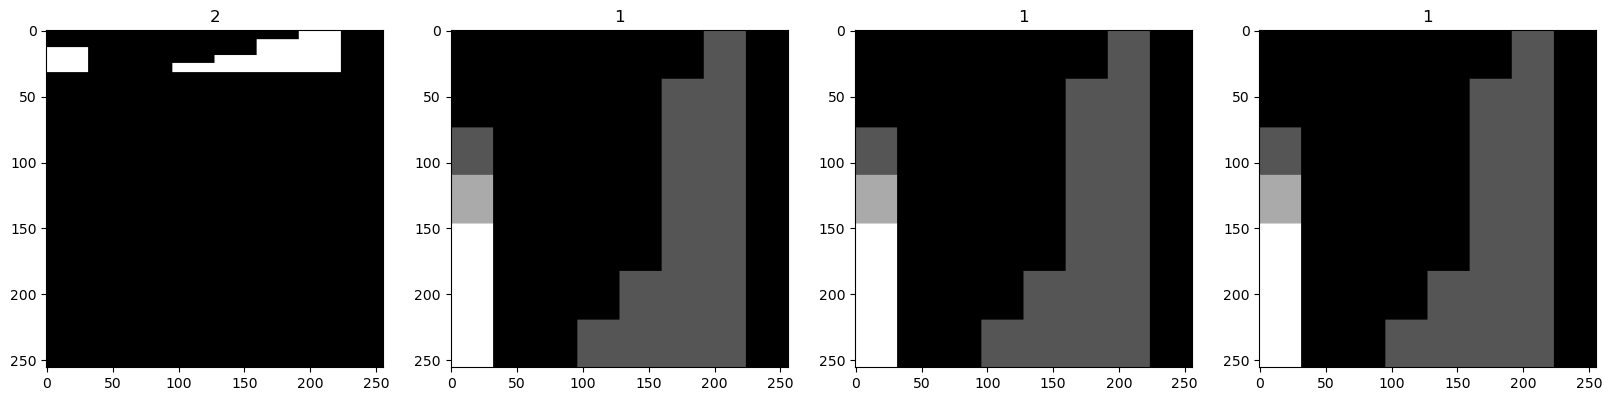

In [11]:
model_loader.load_scale_data(True)

#### Split the data into training, validation, and test sets

In [12]:
model_loader.split_data(0.7, 0.2, 0.1)

Whole data size is 93
Training data size is 65


#### Create a model with 10 epochs and autotune

In [13]:
model, info_data = model_loader.create_model(10, True)

Epoch 1/10
65/65 [==============================] - 85s 1s/step - loss: 1.8687 - accuracy: 0.4630 - val_loss: 1.3560 - val_accuracy: 0.3420
Epoch 2/10
65/65 [==============================] - 101s 2s/step - loss: 0.4542 - accuracy: 0.8274 - val_loss: 1.4515 - val_accuracy: 0.3420
Epoch 3/10
65/65 [==============================] - 98s 2s/step - loss: 0.2057 - accuracy: 0.9312 - val_loss: 1.5096 - val_accuracy: 0.3420
Epoch 4/10
65/65 [==============================] - 91s 1s/step - loss: 0.1090 - accuracy: 0.9716 - val_loss: 1.3777 - val_accuracy: 0.3854
Epoch 5/10
65/65 [==============================] - 83s 1s/step - loss: 0.0855 - accuracy: 0.9769 - val_loss: 0.9948 - val_accuracy: 0.4097
Epoch 6/10
65/65 [==============================] - 101s 2s/step - loss: 0.0541 - accuracy: 0.9885 - val_loss: 0.5159 - val_accuracy: 0.9115
Epoch 7/10
65/65 [==============================] - 93s 1s/step - loss: 0.0421 - accuracy: 0.9918 - val_loss: 0.2140 - val_accuracy: 0.9705
Epoch 8/10
65/65 [

#### Save the model and information data

In [14]:
ModelLoader.save_model(model, "models", "model_14-1", info_data, "info_data", "info_data_14-1")

#### Plot the performance of the model

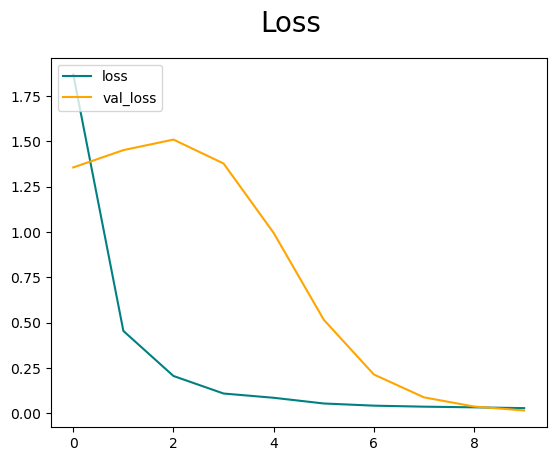

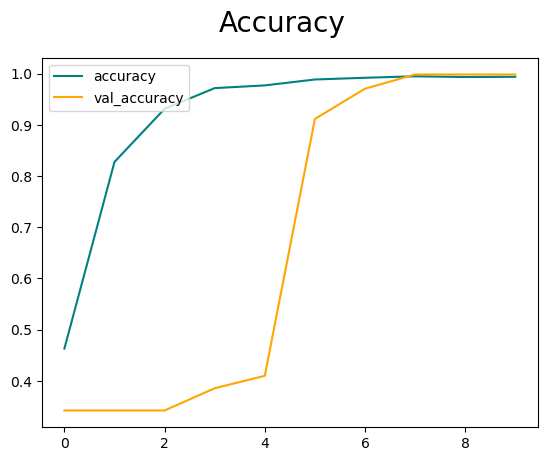

In [15]:
model_loader.plot_model_performance()

#### Examine information data

In [16]:
info_data

({'A': 0, 'B': 1, 'C': 2, 'End': 3, 'Icmp': 4, 'Ist': 5, 'Start': 6, 'T': 7},
 ['pattern_between_after_before',
  'pattern_bounded_3_times',
  'pattern_exist_act_uni',
  'pattern_response_direct'])

### Load the saved model and extract model object, activity dictionary, and class names

In [24]:
model_data = ModelLoader.load_built_model('info_data/info_data_14-1.json')
model = load_model(model_data[0])
act_dict = model_data[1][0]
class_names = model_data[1][1]

## Perform predictions

#### Create a LogLoader object with mode 0, providing the necessary parameters

In [27]:
log_loader = LogLoader(0, "data_3/JSON/data.json", act_dict, "data_3/XES_NETS/test_net_1_RD_BetwAB_patterns.xes", "data_3/Log_Images_Bound3T_EAU", "concept:instance", "concept:name", "time:timestamp")

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

#### Alternatively, create a LogLoader object with mode 1, reading data from a JSON file

In [28]:
#log_loader = LogLoader(1, "data_2/JSON/data.json")

#### Get the image trace data by calling the get_img_trace_data() method on the LogLoader object

In [29]:
data = log_loader.get_img_trace_data()

#### Create an empty dictionary to store the detected classes and their traces

In [30]:
classes = {}

#### Loop through each image path and corresponding trace in the data

In [31]:
for img_path, trace in data:
    # Load and resize image so it would be suitable for a neural network
    image = cv2.imread(img_path)
    resize = tf.image.resize(image, (256,256))
    
    # Predict the class of the image using the pre-trained model
    yhat = model.predict(np.expand_dims(resize/255, 0), verbose = 0)
    img_pattern_class = class_names[np.argmax(yhat)]
    
    # If neural network confidence (softmax layer) is more than 85 percent
    if (np.max(yhat) > 0.85):
        # If the detected class is not in the dictionary, add it and its trace to the dictionary
        if img_pattern_class not in classes:
            classes[img_pattern_class] = trace

        # If the detected class is already in the dictionary, add the trace to the existing traces for that class
        classes[img_pattern_class] + trace

#### Visualize the results for each found pattern by creating its' Petri net

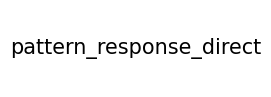

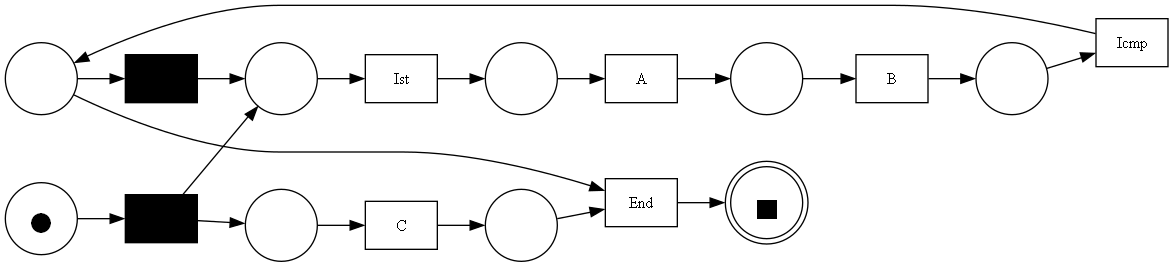

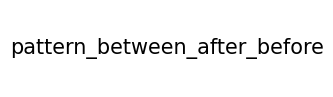

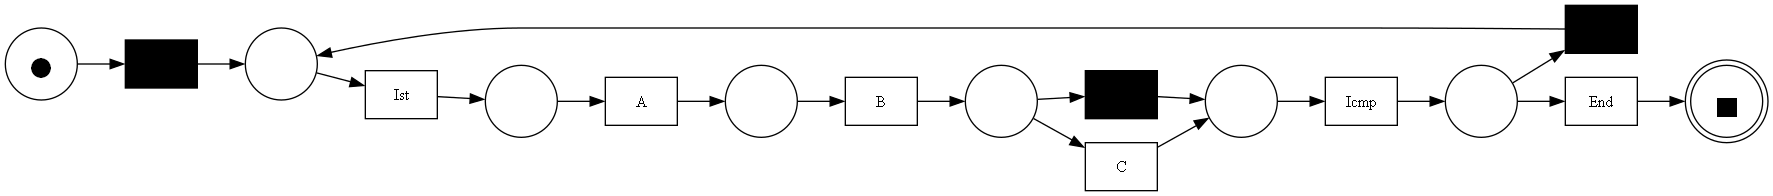

In [32]:
%%capture --no-display
for key in classes:
    
    # Setting up the visualization
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.axis('off')
    ax.text(0.1, 0.5, key, ha='center', va='center', fontsize=15)
    plt.show()
    
    # Connecting all traces of pattern to one pm4py event log
    log = pd.DataFrame(classes[key])
    log[2] = pd.to_datetime(log[2])
    log.columns = ['Activity_Name', 'CaseID', 'CompleteTimestamp']
    format_df = pm4py.format_dataframe(log, case_id = 'CaseID', activity_key = 'Activity_Name', timestamp_key = 'CompleteTimestamp')
    event_log = pm4py.convert_to_event_log(format_df)
    
    # Creat Petri net using Inductive Miner
    net, im, fm = pm4py.discover_petri_net_inductive(event_log)
    
    # Plot Petri net
    pm4py.view_petri_net(net, im, fm, format = 'png')